In [ ]:
#Mengupdate / memperbarui paket data sistem
!sudo apt update

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
52 packages can be upgraded. Run 'apt list --upgradable' to see them.
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InR

In [ ]:
# Menginstal paket pengembangan OpenCV untuk dapat menggunakan OpenCV
!sudo apt install libopencv-dev

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libopencv-dev is already the newest version (4.5.4+dfsg-9ubuntu4+jammy0).
0 upgraded, 0 newly installed, 0 to remove and 52 not upgraded.


In [ ]:
#Menginstall ekstensi nvcc melalui github ke google collab
!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git

  Cloning https://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-82i9aec1
  Running command git clone --filter=blob:none --quiet https://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-82i9aec1
  Resolved https://github.com/andreinechaev/nvcc4jupyter.git to commit 28f872a2f99a1b201bcd0db14fdbc5a496b9bfd7
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for nvcc4jupyter: filename=nvcc4jupyter-1.2.1-py3-none-any.whl size=10734 sha256=0f52ea9394d9bcc0a62f685634f14eafcc914fbded0db0fcbea14a75e228d4f0
  Stored in directory: /tmp/pip-ephem-wheel-cache-d6zcexs1/wheels/a8/b9/18/23f8ef71ceb0f63297dd1903aedd067e6243a68ea756d6feea
Successfully built nvcc4jupyter


In [ ]:
#Memuat ekstensi nvcc yang telah diinstall kedalam google collab
%reload_ext nvcc4jupyter.plugin

Detected platform "Colab". Running its setup...
Source files will be saved in "/tmp/tmplbcixoww".


In [ ]:
#Menampilkan versi nvcc yang terinstall
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


In [ ]:
#Menginstall library opencv python yang akan digunakan
!pip install opencv-python

In [ ]:
#Mengimport beberapa library yang dibutuhkan
import cv2
import numpy as np
from matplotlib import pyplot as plt

#Membuat fungsi imshow untuk menampilkan gambar
def imshow(title = "Image", image = None, size = 10):
    w, h = image.shape[0], image.shape[1]
    aspect_ratio = w/h #Untuk mempertahankan rasio asli
    plt.figure(figsize=(size * aspect_ratio,size))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.show()

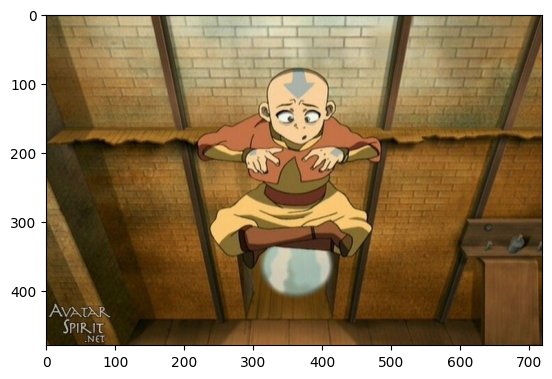

In [ ]:
#Membaca dan menampilkan gambar yang akan digunakan
image = plt.imread("/content/aang.jpg")
plt.imshow(image)
plt.show()

In [ ]:
#Kernel CUDA untuk rotasi 90 dan translasi
code = '''#include <opencv2/opencv.hpp>
#include <cuda_runtime.h>
#include <stdio.h>

// Kernel CUDA untuk translasi gambar
__global__ void translateImage(unsigned char *input, unsigned char *output, int width, int height, int tx, int ty) {
    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;


    if (x < width && y < height) {
        int newX = x + tx;
        int newY = y + ty;
        if (newX < width && newY < height) {
            int inputIdx = (y * width + x) * 3;
            int outputIdx = (newY * width + newX) * 3;

            output[outputIdx] = input[inputIdx];
            output[outputIdx + 1] = input[inputIdx + 1];
            output[outputIdx + 2] = input[inputIdx + 2];
        }
    }
}

// Kernel untuk rotasi 90 derajat untuk gambar berwarna
__global__ void rotate90(unsigned char *input, unsigned char *output, int width, int height) {
    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;

    if (x < width && y < height) {
        // Koordinat baru untuk rotasi 90 derajat searah jarum jam
        int new_x = y;
        int new_y = width - 1 - x;

        // Hitung offset untuk gambar berwarna
        int inputIdx = (y * width + x) * 3;  // 3 karena gambar berwarna (RGB)
        int outputIdx = (new_y * height + new_x) * 3;

        // Salin data untuk setiap kanal (R, G, B)
        output[outputIdx] = input[inputIdx];         // R
        output[outputIdx + 1] = input[inputIdx + 1]; // G
        output[outputIdx + 2] = input[inputIdx + 2]; // B
    }
}

int main() {
    cv::Mat input_image = cv::imread("/content/aang.jpg", cv::IMREAD_COLOR);
    if (input_image.empty()) {
        printf("Failed to read the input image.");
        return -1;
    }

    int width = input_image.cols;
    int height = input_image.rows;

    unsigned char *h_input = input_image.data;
    unsigned char *h_output_trans = new unsigned char[width * height * 3]; // Buffer untuk hasil translasi
    unsigned char *h_output_rot = new unsigned char[width * height * 3];   // Buffer untuk hasil rotasi

    unsigned char *d_input, *d_output;
    cudaMalloc((void**)&d_input, width * height * 3 * sizeof(unsigned char));
    cudaMalloc((void**)&d_output, width * height * 3 * sizeof(unsigned char));

    cudaMemcpy(d_input, h_input, width * height * 3 * sizeof(unsigned char), cudaMemcpyHostToDevice);

    // Tentukan nilai translasi (misalnya pergeseran setengah dari lebar dan tinggi gambar)
    int tx = width / 4;  // Translasi horizontal
    int ty = height / 4; // Translasi vertikal

    // Set ukuran block dan grid
    dim3 blockSize(16, 16);
    dim3 gridSize((width + blockSize.x - 1) / blockSize.x, (height + blockSize.y - 1) / blockSize.y);

    // Panggil kernel untuk translasi gambar
    translateImage<<<gridSize, blockSize>>>(d_input, d_output, width, height, tx, ty);

    // Salin hasil translasi ke host
    cudaMemcpy(h_output_trans, d_output, width * height * 3 * sizeof(unsigned char), cudaMemcpyDeviceToHost);

    // Buat gambar keluaran translasi dengan ukuran asli
    cv::Mat output_trans_image(height, width, CV_8UC3, h_output_trans);
    cv::imwrite("/content/translated_image.jpg", output_trans_image);
    printf("Translated image saved as translated_image.jpg.");

    // Panggil kernel untuk rotasi 90 derajat
    rotate90<<<gridSize, blockSize>>>(d_input, d_output, width, height);

    // Salin hasil rotasi ke host
    cudaMemcpy(h_output_rot, d_output, width * height * 3 * sizeof(unsigned char), cudaMemcpyDeviceToHost);

    // Buat gambar keluaran rotasi dengan ukuran baru
    cv::Mat output_rot_image(width, height, CV_8UC3, h_output_rot); // Gambar baru berukuran width x height setelah rotasi
    cv::imwrite("/content/trans_rotated_90.jpg", output_rot_image);
    printf("Rotated image saved as trans_rotated_90.jpg.");

    // Bersihkan memori
    cudaFree(d_input);
    cudaFree(d_output);
    delete[] h_output_trans;
    delete[] h_output_rot;

    return 0;
}

'''

In [ ]:
# Menyimpan kode translasi ke file translationimg.cu
with open('translationimg.cu', 'w') as file:
    file.write(code)

In [ ]:
# Menyimpan kode rotasi ke file rotation90.cu
with open('rotation90.cu', 'w') as file:
    file.write(code)

In [ ]:
# Compile kode translasi menggunakan CUDA nvcc
!nvcc -o translation translationimg.cu `pkg-config --cflags --libs opencv4` -diag-suppress 611

# Menjalankan kode CUDA
!./translation

Failed to read the input image.

In [ ]:
# Compile kode rotasi menggunakan CUDA nvcc
!nvcc -o rotation rotation90.cu `pkg-config --cflags --libs opencv4` -diag-suppress 611

# Menjalankan kode CUDA
!./rotation

Failed to read the input image.

Translated image saved as translated_image.jpg.Rotated image saved as trans_rotated_90.jpg.

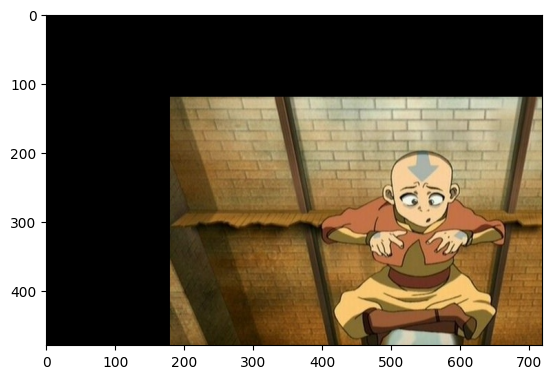

Translated image saved as translated_image.jpg.Rotated image saved as trans_rotated_90.jpg.

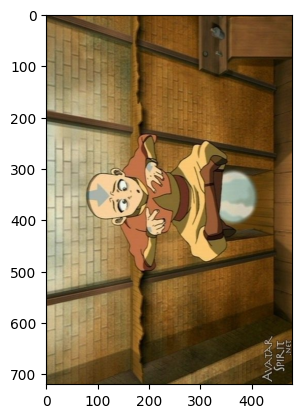

Execution time: 1.4156334400177002 seconds


In [ ]:
import time

# Waktu perhitungan dimulai
start_time = time.time()

# Menjalankan kode CUDA
!./translation
image_trans = plt.imread("/content/translated_image.jpg")
plt.imshow(image_trans)
plt.show()

!./rotation
image_rotate = plt.imread("/content/trans_rotated_90.jpg")
plt.imshow(image_rotate)
plt.show()

# Pewaktuan selesai
end_time = time.time()

# Menampilkan hasil waktu eksekusi
print(f"Execution time: {end_time - start_time} seconds")